### Visualization from lecture to get an overview

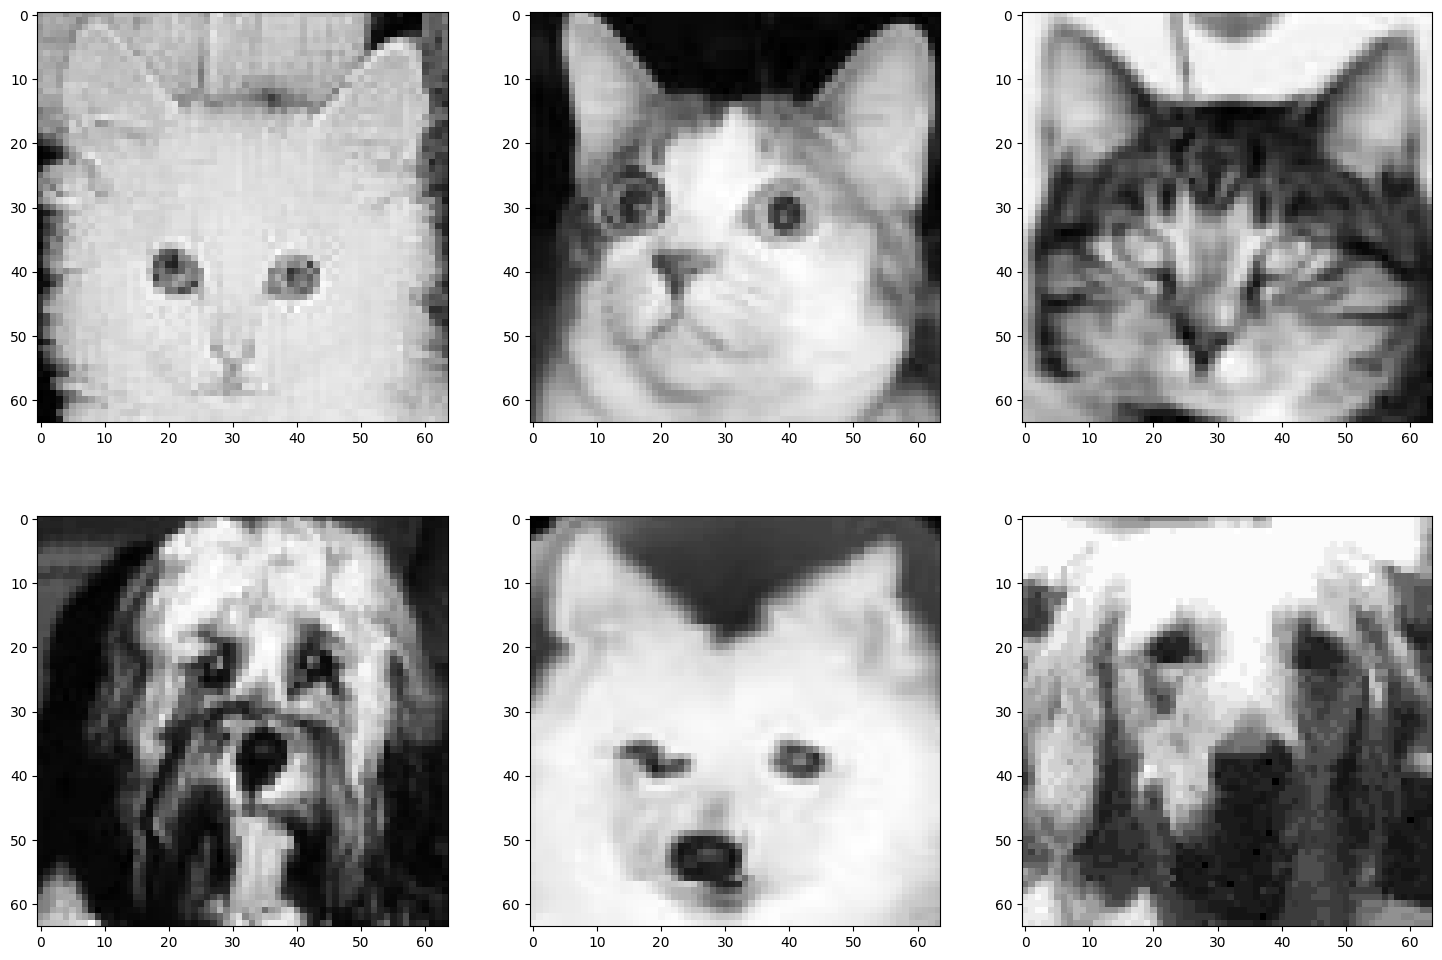

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import trange

CATSnDOGS = np.array(pd.read_csv("CATSnDOGS.csv"))
Labels = np.array(pd.read_csv("Labels.csv"))


def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

np.random.seed(1000012)
ssc = np.random.choice(np.where(Labels == 0)[0], 3, replace=False)
ssd = np.random.choice(np.where(Labels == 1)[0], 3, replace=False)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

for i in range(3):
    axes[0][i].imshow(rotateM(np.reshape(CATSnDOGS[ssc[i], :], (64, 64))), cmap='gray')
    axes[0][i].set_xlabel("")
    axes[0][i].set_ylabel("")
    
for i in range(3):
    axes[1][i].imshow(rotateM(np.reshape(CATSnDOGS[ssd[i], :], (64, 64))), cmap='gray')
    axes[1][i].set_xlabel("")
    axes[1][i].set_ylabel("")

plt.show()

In [ ]:
def get_misclassified_indices(clf, features, labels, dataset):
    # Make predictions on the input data
    y_pred = clf.predict(features)
    
    # Find misclassified samples
    misclassified_idx = [i for i in range(len(labels)) if labels[i] != y_pred[i]]
    misclassified = features[misclassified_idx]
    
    # Find indices of misclassified samples in the original dataset
    indices = []
    for i in range(misclassified.shape[0]):
        image = misclassified[i,:]
        idx = np.where((dataset==image).all(axis=1))[0][0]
        indices.append(idx)
    
    return indices

In [ ]:
# Classifiers
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)


svm = make_pipeline(
    StandardScaler(),
    SVC()
)

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,))
)


In [4]:
lr_list = []
svm_list = []
rf_list = []
mlp_list = []

iterations = 200
for i in trange(iterations):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(CATSnDOGS, Labels.ravel(), test_size=0.2)

    # Train the classifiers using the pipeline
    lr.fit(train_features, train_labels)
    svm.fit(train_features, train_labels)
    rf.fit(train_features, train_labels)
    mlp.fit(train_features, train_labels)

    # Make predictions on the testing data and calculate the accuracies
    lr_pred = lr.predict(test_features)
    lr_acc = accuracy_score(test_labels, lr_pred)

    svm_pred = svm.predict(test_features)
    svm_acc = accuracy_score(test_labels, svm_pred)

    rf_pred = rf.predict(test_features)
    rf_acc = accuracy_score(test_labels, rf_pred)

    mlp_pred = mlp.predict(test_features)
    mlp_acc = accuracy_score(test_labels, mlp_pred)

    
    lr_list.append(lr_acc)
    svm_list.append(svm_acc)
    rf_list.append(rf_acc)
    mlp_list.append(mlp_acc)
    
    
# Print the test accuracies
print("Logistic Regression Accuracy:", np.mean(lr_list))
print("Support Vector Machine Accuracy:", np.mean(svm_list))
print("Random Forest Accuracy:", np.mean(rf_list))
print("MLP Accuracy:", np.mean(np.mean(mlp_list)))

Logistic Regression Accuracy: 0.7527499999999999
Support Vector Machine Accuracy: 0.8022499999999999
Random Forest Accuracy: 0.7502500000000001
MLP Accuracy: 0.7855


### Reflection
Based on the results of the classifiers tested, it appears that the cats and dogs are relatively well separated, with classification accuracies ranging from 75% to 80%. This suggests that there is some overlap between the two categories, but the classifiers are still able to distinguish between them with a relatively high degree of accuracy. It may be useful to explore other metrics beyond accuracy, such as precision, recall, and F1-score, in order to get a more comprehensive picture of the performance of the classifiers.

In [109]:
def common(counts, threshold):
    most_common = []
    for key, count in counts.items():
        if count > threshold:
            most_common.append(key)
    most_common = sorted(most_common, key=lambda key: counts[key], reverse=True)
    return most_common

In [121]:
from collections import Counter

# Define lists to store the misclassified indices for each classifier
lr_indices_list = []
svm_indices_list = []
rf_indices_list = []
mlp_indices_list = []
all_indices = []

iterations = 200


for i in trange(iterations):
    
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(CATSnDOGS, Labels.ravel(), test_size=0.2)

    # Train the classifiers using the pipeline
    lr.fit(train_features, train_labels)
    svm.fit(train_features, train_labels)
    rf.fit(train_features, train_labels)
    mlp.fit(train_features, train_labels)

    # Make predictions on the testing data
    lr_pred = lr.predict(test_features)
    svm_pred = svm.predict(test_features)
    rf_pred = rf.predict(test_features)
    mlp_pred = mlp.predict(test_features)

    # Get misclassified indices for each classifier and store them in separate lists
    lr_indices = get_misclassified_indices(lr, test_features, test_labels, CATSnDOGS)
    lr_indices_list = lr_indices_list + lr_indices
    
    svm_indices = get_misclassified_indices(svm, test_features, test_labels, CATSnDOGS)
    svm_indices_list = svm_indices_list + svm_indices
    
    rf_indices = get_misclassified_indices(rf, test_features, test_labels, CATSnDOGS)
    rf_indices_list = rf_indices_list + rf_indices
    
    mlp_indices = get_misclassified_indices(mlp, test_features, test_labels, CATSnDOGS)
    mlp_indices_list = mlp_indices_list + mlp_indices

    indices = lr_indices + svm_indices + rf_indices + mlp_indices
    all_indices = all_indices + indices


    
    
lr_counts = Counter(lr_indices_list)
svm_counts = Counter(svm_indices_list)
rf_counts = Counter(rf_indices_list)
mlp_counts = Counter(mlp_indices_list) 
    
## For separate classifiers
threshold_sep = iterations*0.2
lr_common = common(lr_counts, threshold_sep)
svm_common = common(svm_counts, threshold_sep)
rf_common = common(rf_counts, threshold_sep)
mlp_common = common(mlp_counts, threshold_sep)

# Find common elements between Logistic Regression and SVM
lr_svm_common = set(lr_common).intersection(set(svm_common))

# Find common elements between Logistic Regression, SVM, and Random Forest
lr_svm_rf_common = set(lr_common).intersection(set(svm_common)).intersection(set(rf_common))

# Find common elements between all arrays
all_common = set(lr_common).intersection(set(svm_common)).intersection(set(rf_common)).intersection(set(mlp_common))

print('Common elements between Logistic Regression and SVM:', lr_svm_common)
print('Common elements between Logistic Regression, SVM, and Random Forest:', lr_svm_rf_common)
print('Common elements between all arrays:', all_common)


## For all classifiers
# If a image was misclassified more than 20% of the time
counts = Counter(all_indices)
nr_clfs = 4
threshold = nr_clfs * iterations * 0.2
most_common = common(counts, threshold)

# Print most common misclassified images
print(f'Most common misclassified images: {most_common}')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:46<00:00,  2.03s/it]

Common elements between Logistic Regression and SVM: {98, 8, 12, 112, 114, 54, 151, 93, 63}
Common elements between Logistic Regression, SVM, and Random Forest: {8, 112, 114, 54, 151, 93}
Common elements between all arrays: {8, 112, 114, 54, 151, 93}
Most common misclassified images: [114, 112, 54, 151, 8, 93, 90, 63, 180]


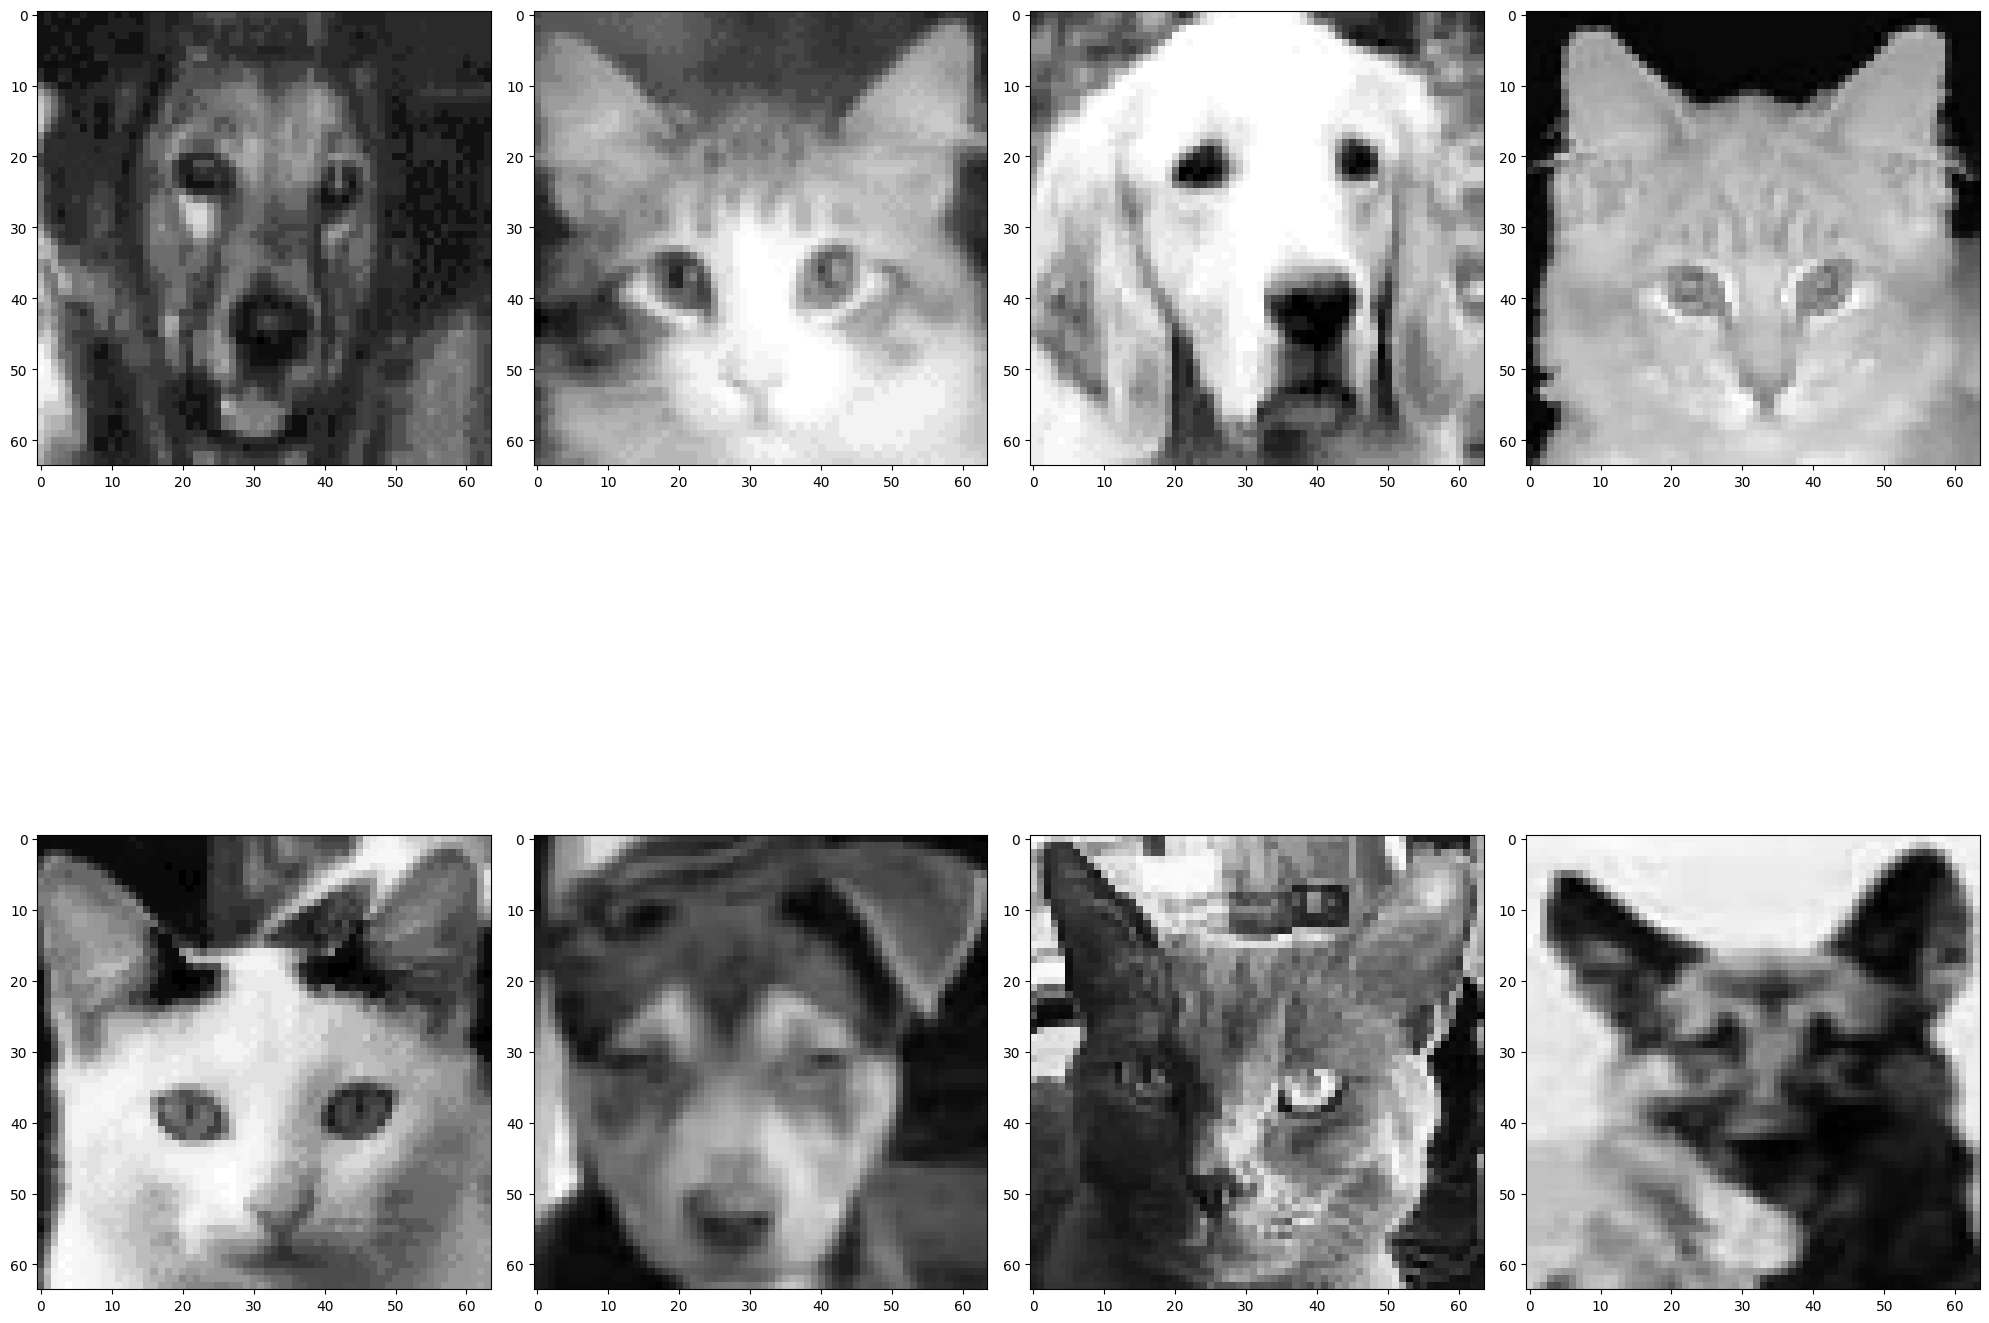

In [122]:
# Show the 8 most misclassified images
rows = 2
cols = 4
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(CATSnDOGS[most_common[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        id += 1
plt.tight_layout()